In [1]:
#import necessary packages for computation
import numpy as np
import xarray as xr
from scipy import stats,signal
import scipy.fftpack as fftpack
from scipy.interpolate import interp1d,CubicSpline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import cartopy.crs as ccrs
from math import *
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings("ignore")

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
#Import Function calculating the annomaly correlation coefficient
#Use .apply_ufunc instead of xarray automated (more efficient)
def acc_fun(f,o):
    subf = lambda x,y:x-y
    multf = lambda x,y: x*y
    sqf = lambda x:x**2
    radf = lambda x:x**0.5
    divf = lambda x,y:x/y
    
    fclim =  f.mean(dim = 'time')
    oclim = o.mean(dim = 'time')
    fanom = xr.apply_ufunc(subf, f, fclim)
    oanom = xr.apply_ufunc(subf, o, oclim)
    
    num = xr.apply_ufunc(multf,fanom,oanom).sum(dim='time')
    
    fanomsq = xr.apply_ufunc(sqf, fanom).sum(dim ='time')
    oanomsq = xr.apply_ufunc(sqf, oanom).sum(dim ='time')
    
    fanomrad = xr.apply_ufunc(radf, fanomsq)
    oanomrad = xr.apply_ufunc(radf, oanomsq)
    
    
    den = xr.apply_ufunc(multf, fanomrad,oanomrad)
    
    acc = xr.apply_ufunc(divf, num,den)
    return acc

In [3]:
#Function calculating the mean squared skill score
def mss_fun(f,o):
    squared_error = lambda x, y: (x - y) ** 2
    divf = lambda x,y:x/y
    
    oclim = o.mean(dim = 'time')

    num = xr.apply_ufunc(squared_error, f, o).sum(dim='time')
    den = xr.apply_ufunc(squared_error, o, oclim).sum(dim='time')
    mss = 1-xr.apply_ufunc(divf,num,den)
    return mss

In [4]:
#Function calculating the skill across ensembles
def ap_ensemble (f,o):
    acc_out=f.mean(dim='time').copy(deep=True)
    mss_out=f.mean(dim='time').copy(deep=True)
    for i in range(len(f.number.values)):
        f_cur=f.isel(number=i)
        acc_cur = acc_fun(f_cur,o)
        mss_cur=mss_fun(f_cur,o)
        acc_out[:,i]=acc_cur
        mss_out[:,i]=mss_cur
    return acc_out,mss_out

In [5]:
%matplotlib inline

In [7]:
#BSS function
def BSS(f,o):
    o=observed_data[models[i]].q
    f=forecast_data[models[i]].q

    ot95=xr.where(o>o.quantile(0.95,dim='time'),1,0)
    bsf=(ot95.mean(dim='time'))*(1.-ot95.mean(dim='time'))

    ft95=xr.where(f>f.quantile(0.95,dim='time'),1,0)
    pk=ft95.mean(dim='number')

    bs=((pk-ot95)**2).mean(dim='time')
    bss=1-(bs/bsf)

    return bss
        
        

In [8]:
#Read unsmoothed data in if already computed
forecast_data = {}
observed_data = {}
models = ['ecmwf','cma','hmcr','meteof']
for i in range(4):
    observed_data[models[i]]=xr.open_dataset(models[i]+'/output/nosmooth_era_nov_jan.nc')
    forecast_data[models[i]]=xr.open_dataset(models[i]+'/output/nosmooth_'+models[i]+'_nov_jan.nc')

In [9]:
#ECMWF version 2
ecmwf_ext_fo = xr.open_dataset(models[0]+'/output/nosmooth_ecmwf_v2016full.nc')
ecmwf_ext_ob = xr.open_dataset(models[0]+'/output/nosmooth_era_v2016full.nc')
forecast_data['execm']=ecmwf_ext_fo
observed_data['execm']=ecmwf_ext_ob

## Compute climatologies and evaluation metrics

In [ ]:
#Calculate acc and msss using ensemble mean forecast
models = ['ecmwf','cma','hmcr','meteof','execm']
acc_mean = {}
mss_mean = {}
acc_ens = {}
#mss_ens={}
bss_ens={}
for i in range(len(models)):
    f_ensmn = forecast_data[models[i]].q.mean(dim='number')
    ocur=observed_data[models[i]].q
    acc_mean[models[i]]=acc_fun(f_ensmn,ocur)
    mss_mean[models[i]]=mss_fun(f_ensmn,ocur)
    
    fcur=forecast_data[models[i]].q
    bss_ens[models[i]]=BSS(fcur,ocur)
#    acc_ens[models[i]],mss_ens[models[i]]=ap_ensemble(fcur,ocur)


## Plot results

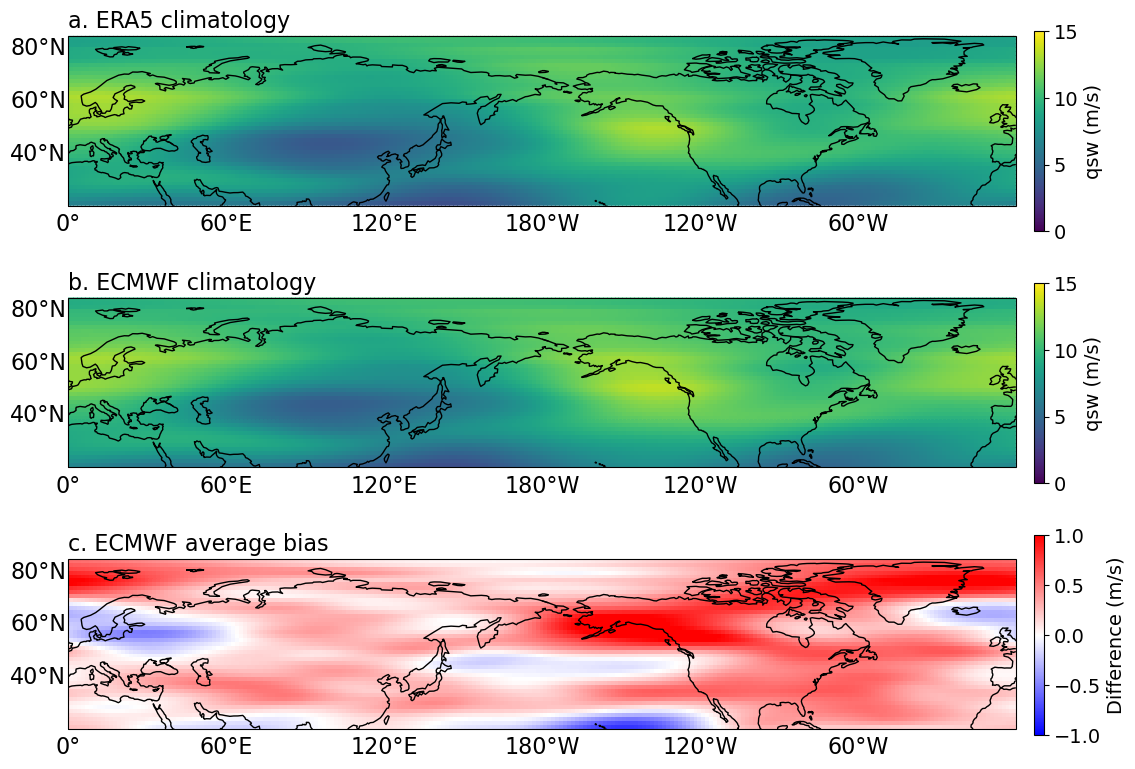

In [13]:
#Plot QSW climatology using initial step only
models1 = ['ECMWF','CMA','HMCR','Météo-France']
cm=180
fig = plt.figure(figsize=(20,8))
proj = ccrs.PlateCarree(central_longitude=cm)
ax = fig.add_subplot(3,2,1,projection=proj)
ax.coastlines()
fg=observed_data[models[0]].q.isel(step=slice(7,22)).mean(dim=['step','time']).plot(ax=ax,vmin = 0, vmax = 15,transform = ccrs.PlateCarree(),add_colorbar=False)

ax.set_title('')
ax.set_title('a. ERA5 climatology', fontsize = 16, loc='left')

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.ylocator = mticker.FixedLocator([0,20, 40, 60, 80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

cbar_ax = fig.add_axes([0.52, 0.69, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="qsw (m/s)",size=14)
cbl.ax.tick_params(labelsize=14)

ax = fig.add_subplot(3,2,3,projection=proj)
ax.coastlines()
fg=forecast_data[models[0]].q.isel(step=slice(7,22)).mean(dim=['step','time','number']).plot(ax=ax,vmin = 0, vmax = 15, transform = ccrs.PlateCarree(),add_colorbar=False)

ax.set_title('')
ax.set_title('b. ECMWF climatology', fontsize = 16, loc='left')

cbar_ax = fig.add_axes([0.52, 0.375, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="qsw (m/s)",size=14)
cbl.ax.tick_params(labelsize=14)

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.ylocator = mticker.FixedLocator([0,20, 40, 60, 80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

titles = [ 'b.', 'c.', 'd.', 'e.']

ax = fig.add_subplot(3,2,5,projection=proj)
fg=(forecast_data[models[0]].q.isel(step=slice(7,22)).mean(dim=['step','time','number'])-observed_data[models[0]].q.isel(step=slice(7,22)).mean(dim=['step','time'])).plot(ax=ax,cmap = 'bwr', vmax = 1, transform = ccrs.PlateCarree(),add_colorbar=False)

ax.set_title('')
ax.set_title('c. '+models1[0]+' average bias',fontsize = 16, loc='left')
ax.coastlines()

cbar_ax = fig.add_axes([0.52, 0.06, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="Difference (m/s)",size=14)
cbl.ax.tick_params(labelsize=14)

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

gl.ylocator = mticker.FixedLocator([0,20, 40, 60, 80])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.tight_layout()

# plt.show()
plt.savefig('plots/Climatology_bias_ecmwf_ERA_s2s.png')

In [19]:
#Model names
models1 = ['ECMWF','CMA','HMCR','CNRM']

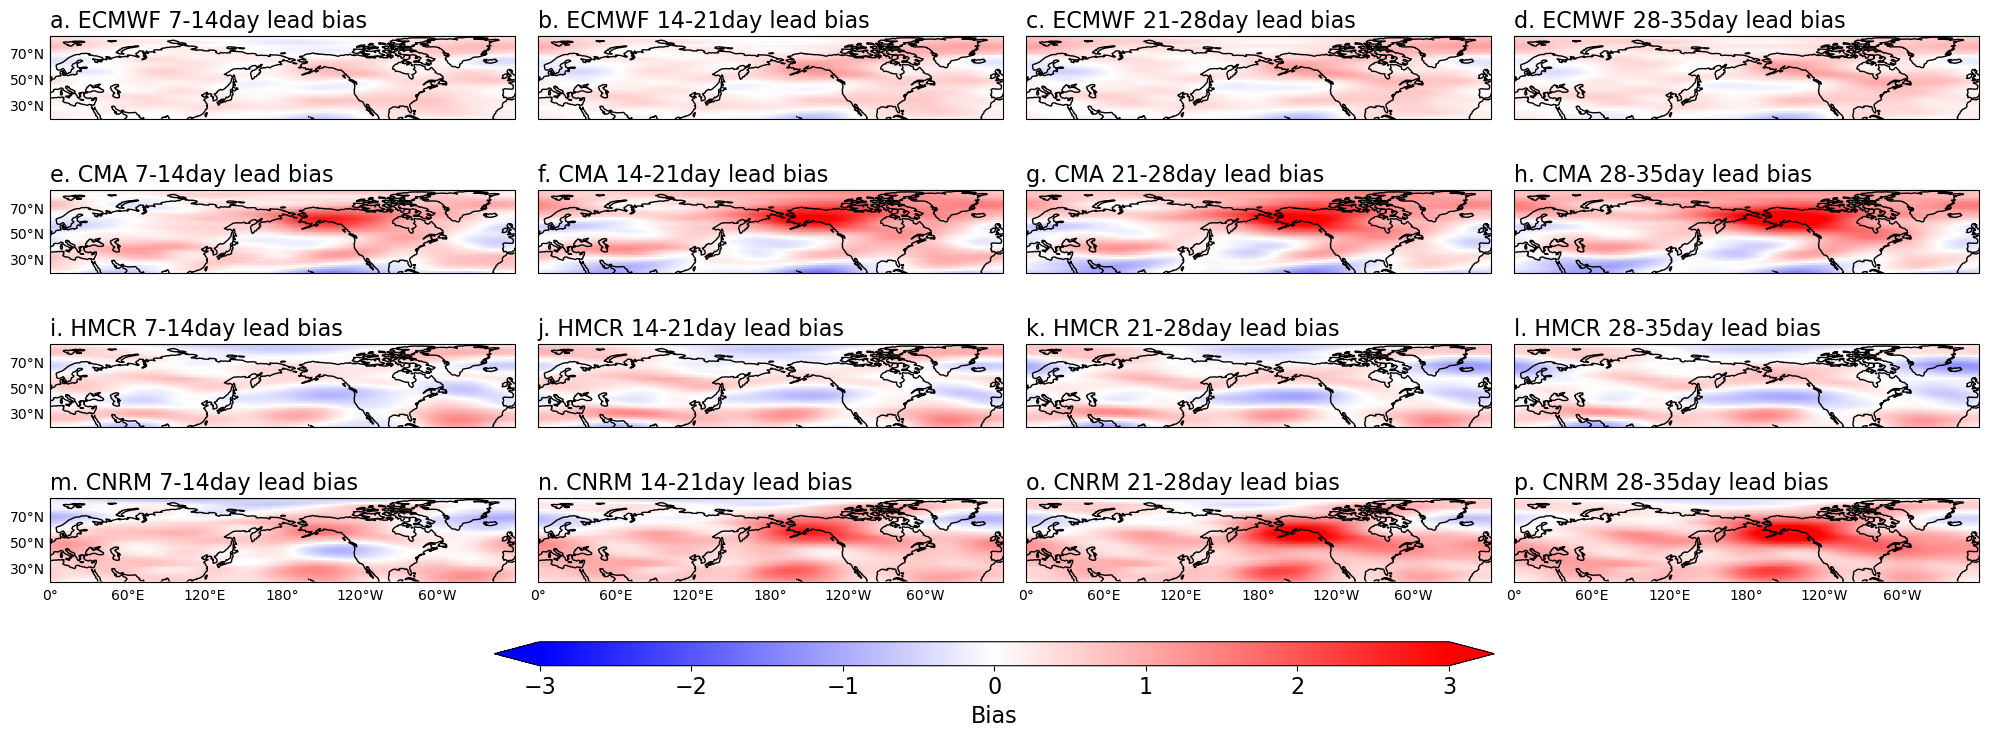

In [19]:
#Plot QSW bias at various lead times
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(20,8))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [[ 'a. ', 'b. ', 'c. ', 'd. '], [ 'e. ', 'f. ', 'g. ', 'h. '], [ 'i. ', 'j. ', 'k. ', 'l. '], [ 'm. ', 'n. ', 'o. ', 'p. ']]
for i in range (len(models1)):

    #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

    ax = fig.add_subplot(len(models)+1,4,4*i+1,projection=proj)
    (forecast_data[models[i]].q.isel(step=slice(0,8)).mean(dim=['time','number','step'])-observed_data[models[i]].q.isel(step=slice(0,8)).mean(dim=['time','step'])).plot(ax=ax,cmap = 'bwr', transform=ccrs.PlateCarree(), vmax = 3, extend='both', add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][0]+models1[i]+' 7-14day lead bias ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    if i<3:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models)+1,4,4*i+2,projection=proj)
    (forecast_data[models[i]].q.isel(step=slice(8,15)).mean(dim=['time','number','step'])-observed_data[models[i]].q.isel(step=slice(8,15)).mean(dim=['time','step'])).plot(ax=ax,cmap = 'bwr', transform=ccrs.PlateCarree(), vmax =3, extend='both', add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][1]+models1[i]+' 14-21day lead bias ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<3:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models)+1,4,4*i+3,projection=proj)
    (forecast_data[models[i]].q.isel(step=slice(15,22)).mean(dim=['time','number','step'])-observed_data[models[i]].q.isel(step=slice(15,22)).mean(dim=['time','step'])).plot(ax=ax,cmap = 'bwr', transform=ccrs.PlateCarree(), vmax = 3, extend='both', add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][2]+models1[i]+' 21-28day lead bias ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<3:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models)+1,4,4*i+4,projection=proj)
    m=(forecast_data[models[i]].q.isel(step=slice(22,28)).mean(dim=['time','number','step'])-observed_data[models[i]].q.isel(step=slice(22,28)).mean(dim=['time','step'])).plot(ax=ax,cmap = 'bwr', transform=ccrs.PlateCarree(), vmax = 3, extend='both', add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][3]+models1[i]+' 28-35day lead bias ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<3:
        gl.xlabels_bottom = False

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.03])
cbl=fig.colorbar(m, cax=cbar_ax,extend='both',orientation='horizontal')
cbl.set_label(label="Bias",size=16)
cbl.ax.tick_params(labelsize=16)

plt.subplots_adjust(hspace=0.02, bottom=0.05)
plt.tight_layout()
#plt.show()
plt.savefig('plots/All_model_bias_leadtime.png')
plt.show()

In [20]:
#Rotate longitude of metrics
acc_mean_rot={}
for i in range(len(models1)):
    acc_mean_rot[models[i]]=acc_mean[models[i]].copy()
    acc_mean_rot[models[i]].coords['longitude']= acc_mean_rot[models[i]].coords['longitude']  % 360 
    acc_mean_rot[models[i]] = acc_mean_rot[models[i]].sortby(acc_mean_rot[models[i]].longitude)
mss_mean_rot={}
for i in range(len(models1)):
    mss_mean_rot[models[i]]=mss_mean[models[i]].copy()
    mss_mean_rot[models[i]].coords['longitude']= mss_mean_rot[models[i]].coords['longitude']  % 360 
    mss_mean_rot[models[i]] = mss_mean_rot[models[i]].sortby(mss_mean_rot[models[i]].longitude)
bss_ens_rot={}
for i in range(len(models1)):
    bss_ens_rot[models[i]]=bss_ens[models[i]].copy()
    bss_ens_rot[models[i]].coords['longitude']= bss_ens_rot[models[i]].coords['longitude']  % 360 
    bss_ens_rot[models[i]] = bss_ens_rot[models[i]].sortby(bss_ens_rot[models[i]].longitude)

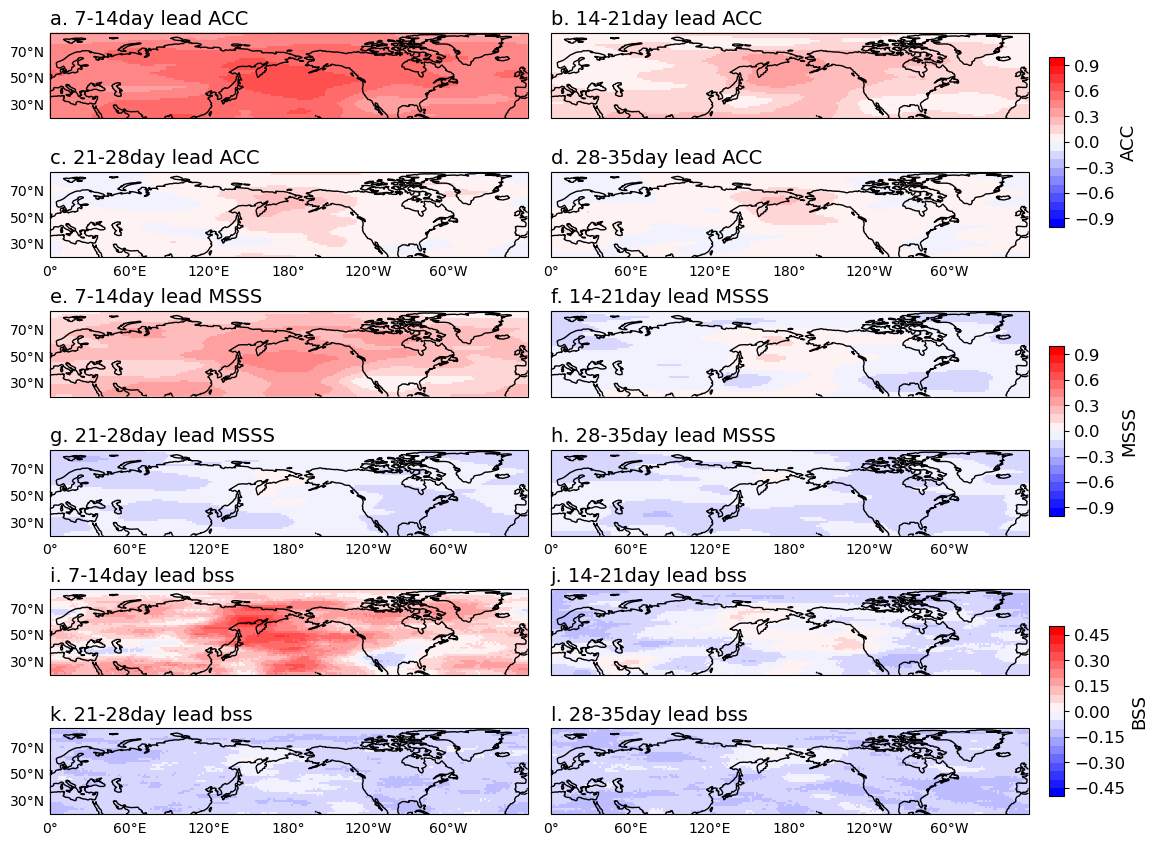

In [40]:
#Plot QSW acc for ecmwf across leadime
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(15.5,8.5))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [ 'a. ', 'b. ', 'c. ', 'd. ']
   #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

ax = fig.add_subplot(6,3,1,projection=proj)
acc_mean_rot[models[0]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('a. 7-14day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,2,projection=proj)
acc_mean_rot[models[0]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('b. 14-21day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,4,projection=proj)
acc_mean_rot[models[0]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('c. 21-28day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,5,projection=proj)
m=acc_mean_rot[models[0]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('d. 28-35day lead ACC ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.73, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="ACC",size=13)
cbl.ax.tick_params(labelsize=12)

ax = fig.add_subplot(6,3,7,projection=proj)
mss_mean_rot[models[0]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('e. 7-14day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,8,projection=proj)
mss_mean_rot[models[0]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('f. 14-21day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,10,projection=proj)
mss_mean_rot[models[0]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('g. 21-28day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,11,projection=proj)
m=mss_mean_rot[models[0]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('h. 28-35day lead MSSS ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.39, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="MSSS",size=13)
cbl.ax.tick_params(labelsize=12)

ax = fig.add_subplot(6,3,13,projection=proj)
bss_ens_rot[models[0]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('i. 7-14day lead bss ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,14,projection=proj)
bss_ens_rot[models[0]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('j. 14-21day lead bss ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlabels_bottom = False

ax = fig.add_subplot(6,3,16,projection=proj)
bss_ens_rot[models[0]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('k. 21-28day lead bss ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False



ax = fig.add_subplot(6,3,17,projection=proj)
m=bss_ens_rot[models[0]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
ax.set_title('')
ax.set_title('l. 28-35day lead bss ',fontsize = 14, loc='left')
ax.coastlines()

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.ylabels_left = False


cbar_ax = fig.add_axes([0.68, 0.06, 0.01, 0.2])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='vertical')
cbl.set_label(label="BSS",size=13)
cbl.ax.tick_params(labelsize=12)

plt.subplots_adjust(hspace=0.01,wspace=0.01, bottom=0.2)
plt.tight_layout()
#plt.show()
plt.savefig('plots/ECMWF_skill_leadtime.png')

In [ ]:
#Plot all models ACC across leadtime
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(20,8))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [[ 'a. ', 'b. ', 'c. ', 'd. '], [ 'e. ', 'f. ', 'g. ', 'h. '], [ 'i. ', 'j. ', 'k. ', 'l. '], [ 'm. ', 'n. ', 'o. ', 'p. ']]
for i in range (len(models1)):

    #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

    ax = fig.add_subplot(len(models1)+1,4,4*i+1,projection=proj)
    acc_mean_rot[models[i]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][0]+models1[i]+' 7-14day lead ACC ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+2,projection=proj)
    acc_mean_rot[models[i]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][1]+models1[i]+' 14-21day lead ACC ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+3,projection=proj)
    acc_mean_rot[models[i]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][2]+models1[i]+' 21-28day lead ACC ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+4,projection=proj)
    m=acc_mean_rot[models[i]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][3]+models1[i]+' 28-35day lead ACC ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.03])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="ACC",size=16)
cbl.ax.tick_params(labelsize=16)

plt.subplots_adjust(hspace=0.01, bottom=0.05)
plt.tight_layout()
#plt.show()
plt.savefig('plots/All_models_acc_leadtime.png')
plt.show()

In [ ]:
#Plot all models msss across leadtime
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(20,8))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [[ 'a. ', 'b. ', 'c. ', 'd. '], [ 'e. ', 'f. ', 'g. ', 'h. '], [ 'i. ', 'j. ', 'k. ', 'l. '], [ 'm. ', 'n. ', 'o. ', 'p. ']]
for i in range (len(models1)):

    #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

    ax = fig.add_subplot(len(models1)+1,4,4*i+1,projection=proj)
    mss_mean_rot[models[i]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][0]+models1[i]+' 7-14day lead MSSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+2,projection=proj)
    mss_mean_rot[models[i]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][1]+models1[i]+' 14-21day lead MSSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+3,projection=proj)
    mss_mean_rot[models[i]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][2]+models1[i]+' 21-28day lead MSSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+4,projection=proj)
    m=mss_mean_rot[models[i]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=1, vmin=-1,levels=np.arange(-1,1.1,0.1), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][3]+models1[i]+' 28-35day lead MSSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.03])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="MSSS",size=16)
cbl.ax.tick_params(labelsize=16)

plt.subplots_adjust(hspace=0.01, bottom=0.05)
plt.tight_layout()
#plt.show()
plt.savefig('plots/All_models_mss_leadtime.png')

In [ ]:
#Plot all models bss across leadtime
models1 = ['ECMWF','CMA','HMCR','CNRM']
fig = plt.figure(figsize=(20,8))
cm=180

proj = ccrs.PlateCarree(central_longitude=cm)

titles = [[ 'a. ', 'b. ', 'c. ', 'd. '], [ 'e. ', 'f. ', 'g. ', 'h. '], [ 'i. ', 'j. ', 'k. ', 'l. '], [ 'm. ', 'n. ', 'o. ', 'p. ']]
for i in range (len(models1)):

    #Plot QSW climatology for forecast data

    
    #Plot QSW bias betweeen forecast and reanalysis data

    ax = fig.add_subplot(len(models1)+1,4,4*i+1,projection=proj)
    bss_ens_rot[models[i]].isel(step=slice(0,8)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr',  vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][0]+models1[i]+' 7-14day lead BSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+2,projection=proj)
    bss_ens_rot[models[i]].isel(step=slice(8,15)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][1]+models1[i]+' 14-21day lead BSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+3,projection=proj)
    bss_ens_rot[models[i]].isel(step=slice(15,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr',  vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][2]+models1[i]+' 21-28day lead BSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False
     
    ax = fig.add_subplot(len(models1)+1,4,4*i+4,projection=proj)
    m=bss_ens_rot[models[i]].isel(step=slice(22,29)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.55,0.05), transform = ccrs.PlateCarree(), add_colorbar=False)
    ax.set_title('')
    ax.set_title(titles[i][3]+models1[i]+' 28-35day lead BSS ',fontsize = 16, loc='left')
    ax.coastlines()

    gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylabels_left = False
    if i<2:
        gl.xlabels_bottom = False

cbar_ax = fig.add_axes([0.25, 0.15, 0.5, 0.03])
cbl=fig.colorbar(m, cax=cbar_ax,orientation='horizontal')
cbl.set_label(label="BSS",size=16)
cbl.ax.tick_params(labelsize=16)

plt.subplots_adjust(hspace=0.01, bottom=0.05)
plt.tight_layout()

plt.savefig('plots/All_models_bss_leadtime.png')
plt.show()

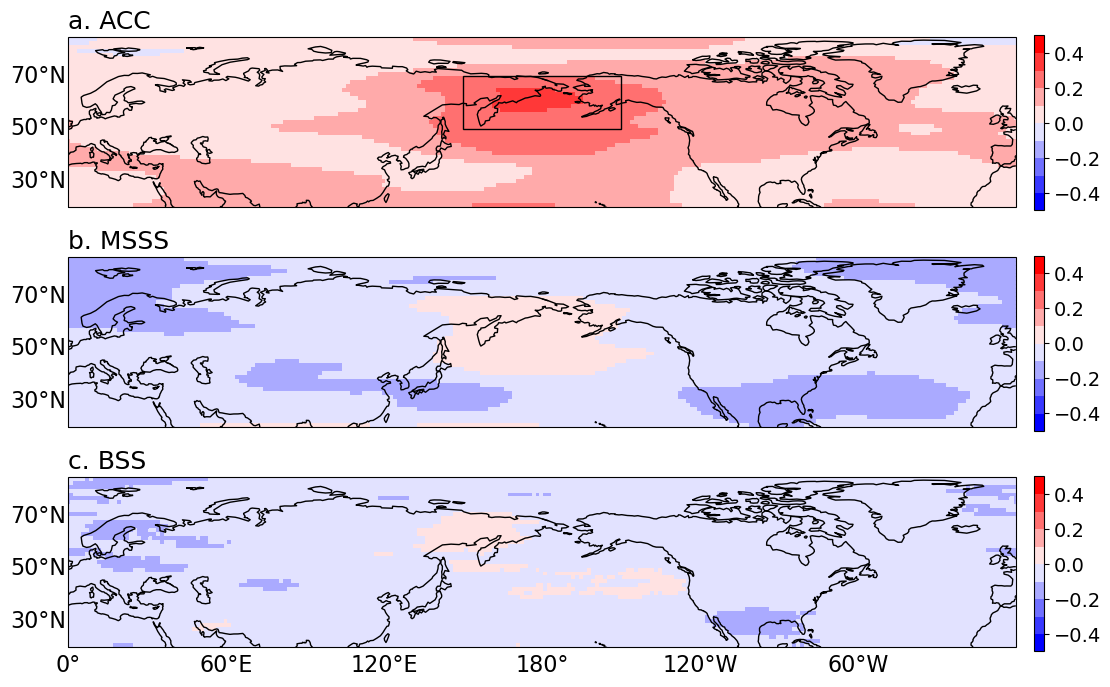

In [41]:
#Plot acc, msss, and bss for ECMWF s2s

fig = plt.figure(figsize=(20,7))
cm=180
proj = ccrs.PlateCarree(central_longitude=cm)
ax = fig.add_subplot(3,2,1,projection=proj)
ax.coastlines()
fg=acc_mean_rot[models[0]].isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.75, vmin=0, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),add_colorbar=False)

cbar_ax = fig.add_axes([0.52, 0.69, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
#cbl.set_label(label="ACC",size=14)
cbl.ax.tick_params(labelsize=14)

ax.set_title(' ')
ax.set_title('a. ACC',fontsize = 18,loc='left')

ax.add_patch(mpatches.Rectangle(xy=[150, 50], width=60, height=20,
                                facecolor='none', edgecolor='k',
                                transform=ccrs.PlateCarree()))
# ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
#                                 facecolor='none', edgecolor='k',
#                                 transform=ccrs.PlateCarree()))



gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

#Plot QSW bias betweeen forecast and reanalysis data
ax = fig.add_subplot(3,2,3,projection=proj)
fg=mss_mean_rot[models[0]].isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5,levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),add_colorbar=False)
ax.set_title(' ')
ax.set_title('b. MSSS',fontsize = 18,loc='left')
ax.coastlines()

cbar_ax = fig.add_axes([0.52, 0.375, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
#cbl.set_label(label="MSSS",size=14)
cbl.ax.tick_params(labelsize=14)

gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.xlabels_bottom = False

gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}

ax = fig.add_subplot(3,2,5,projection=proj)
ax.coastlines()
fg=bss_ens_rot[models[0]].isel(step=slice(7,22)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=0, levels=np.arange(-0.5,0.6,0.1),transform=ccrs.PlateCarree(),add_colorbar=False)
ax.set_title(' ')
ax.set_title('c. BSS',fontsize = 18,loc='left')

cbar_ax = fig.add_axes([0.52, 0.06, 0.005, 0.25])
cbl=fig.colorbar(fg, cax=cbar_ax,orientation='vertical')
#cbl.set_label(label="BSS",size=14)
cbl.ax.tick_params(labelsize=14)
# ax.add_patch(mpatches.Rectangle(xy=[-180, 30], width=30, height=40,
#                                 facecolor='none', edgecolor='k',
#                                 transform=ccrs.PlateCarree()))



gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
# ax = fig.add_subplot(2,2,3,projection=proj)
# ax.coastlines()
# mss_mean[models[0]].isel(step=slice(0,16)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5)
# ax.set_title(models1[0]+' forecast skill (MSSS) in <23 days lead time',fontsize = 18)

# ax.set_title('c.', loc = 'left',fontsize = 18)

# gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
# gl.xlabels_top = False
# gl.ylabels_right = False


# #Plot QSW bias betweeen forecast and reanalysis data
# ax = fig.add_subplot(2,2,4,projection=proj)
# mss_mean[models[0]].isel(step=slice(16,32)).mean(dim=['step']).plot(ax=ax,cmap = 'bwr', vmax=0.5, vmin=-0.5)
# ax.set_title(models1[0]+' forecast skill (MSSS) in >23 days lead time',fontsize = 18)
# ax.coastlines()
# ax.set_title('d.', loc = 'left',fontsize = 18)

# gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True, dms=True, x_inline=False, y_inline=False,color = "None")
# gl.xlabels_top = False
# gl.ylabels_right = False

plt.tight_layout()
plt.savefig('plots/ECMWF_acc_mss_bss_maps_across_lead.png')

## Recalculate metrics across each year and ensemble to look at skill variations

In [ ]:
#Calculate acc and mss on each year for ensemble mean
accyearly={}
mssyearly={}

for i in range (len(models)):
    fcur1 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([11,12])).mean(dim='number')
    ocur1 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([11,12]))

    fcur2 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([1,2])).mean(dim='number')
    ocur2 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    mss_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))
    acc_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))


    accy = acc_y.expand_dims(years = years).copy()
    mssy = mss_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        ocur=xr.concat([ocur11,ocur22],dim='time')
        mssur =mss_fun(fcur,ocur)
        #msser=mssur.sel(step=slice(mssur.step[0],mssur.step[16])).mean(dim=['step'])
        accur =acc_fun(fcur,ocur)
        #accer=accur.sel(step=slice(accur.step[0],accur.step[16])).mean(dim=['step'])
        mssy[j,]=mssur.q.values
        accy[j,]=accur.q.values
        
    accyearly[models[i]]=accy
    mssyearly[models[i]]=mssy

### Use North Pacific Skill

In [ ]:
#yearly pacific acc (70-50)
#Calculate acc and mss on each year for ensemble mean


accpac_topy={}
accpac_boty={}

topy_pac={}
boty_pac={}

accpacific = {}
for i in range (len(models)):
    accyearly[models[i]].coords['longitude'] = (accyearly[models[i]].coords['longitude'] + 180) % 360 - 180
    accyearly[models[i]] = accyearly[models[i]].sortby(accyearly[models[i]].longitude)
    accy = accyearly[models[i]].copy()
    accy.coords['longitude'] = accy.coords['longitude'] % 360
    accy = accy.sortby(accy.longitude)
    accy_pacific=accy.sel(longitude=slice(150,210),latitude=slice(70,50))
    accspy_pac = accy_pacific.mean(dim=['latitude', 'longitude'])
    accspy_st_pac=accspy_pac.mean(dim='step')
    accspy_st_pacav=accspy_st_pac.mean(dim='years')
    accspy_st_pacsd=accspy_st_pac.std(dim='years')
    
    accspsty_topn=accspy_st_pac.where(accspy_st_pac>accspy_st_pacav+accspy_st_pacsd).dropna(dim='years')
    accpac_topy[models[i]]=accyearly[models[i]].sel(years=accspsty_topn.years).mean(dim='years')
    
    accspsty_botn=accspy_st_pac.where(accspy_st_pac<accspy_st_pacav-accspy_st_pacsd).dropna(dim='years')
    accpac_boty[models[i]]=accyearly[models[i]].sel(years=accspsty_botn.years).mean(dim='years')
    
    boty_pac[models[i]]=accspsty_botn.years
    topy_pac[models[i]]=accspsty_topn.years
    
    accpacific[models[i]] = accy_pacific

In [ ]:
#Calculate average QSW on each year for ensemble mean
qsw_yearly={}
qsw_yearly_pac={}

for i in range (4):
    
    fcur1 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([11,12])).mean(dim='number')
    #ocur1 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([11,12]))

    fcur2 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([1,2])).mean(dim='number')
    #ocur2 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    qsw_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))


    qsw_y = acc_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        #ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        #ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        #ocur=xr.concat([ocur11,ocur22],dim='time')

        qsw_cur = fcur.mean(dim='time')
        qsw_y[j,]=qsw_cur.q.values
        
        
    qsw_yearly[models[i]]=qsw_y


    qsw_yearly[models[i]].coords['longitude'] = qsw_yearly[models[i]].coords['longitude'] % 360
    qsw_yearly[models[i]] = qsw_yearly[models[i]].sortby(qsw_yearly[models[i]].longitude)
    
    qsw_yearly[models[i]]=qsw_yearly[models[i]].sel(longitude=slice(150,210),latitude=slice(70,50))
    
    qsw_yearly[models[i]].coords['longitude'] = (qsw_yearly[models[i]].coords['longitude'] + 180) % 360 - 180
    qsw_yearly[models[i]] = qsw_yearly[models[i]].sortby(qsw_yearly[models[i]].longitude)
    


In [ ]:
#Calculate QSW ensemble spread on each year for ensemble mean north pacific
qspread_yearly={}
qspread_yearly_pac={}

for i in range (4):
    
    fcur1 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([11,12])).std(dim='number')
    #ocur1 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([11,12]))

    fcur2 =forecast_data[models[i]].sel(time=forecast_data[models[i]].time.dt.month.isin([1,2])).std(dim='number')
    #ocur2 = observed_data[models[i]].sel(time=observed_data[models[i]].time.dt.month.isin([1,2]))

    years = list(set(fcur1.time.dt.year.values))
    years.sort()

    qsw_y=xr.zeros_like(fcur1.q.sel(time = fcur1.time.dt.year==years[0]).mean(dim='time'))


    qsw_y = acc_y.expand_dims(years = years).copy()


    for j in range(len(years)):
        #month 12
        fcur11 =fcur1.sel(time = fcur1.time.dt.year==years[j])
        #ocur11 = ocur1.sel(time = ocur1.time.dt.year==years[j])
        fcur22 =fcur2.sel(time = fcur2.time.dt.year==years[j]+1)
        #ocur22 = ocur2.sel(time = ocur2.time.dt.year==years[j]+1)

        fcur=xr.concat([fcur11,fcur22],dim='time')
        #ocur=xr.concat([ocur11,ocur22],dim='time')

        qsw_cur = fcur.mean(dim='time')
        qsw_y[j,]=qsw_cur.q.values
        
        
    qspread_yearly[models[i]]=qsw_y


    qspread_yearly[models[i]].coords['longitude'] = qspread_yearly[models[i]].coords['longitude'] % 360
    qspread_yearly[models[i]] = qspread_yearly[models[i]].sortby(qspread_yearly[models[i]].longitude)
    
    qspread_yearly[models[i]]=qspread_yearly[models[i]].sel(longitude=slice(150,210),latitude=slice(70,50))
    
    qspread_yearly[models[i]].coords['longitude'] = (qspread_yearly[models[i]].coords['longitude'] + 180) % 360 - 180
    qspread_yearly[models[i]] = qspread_yearly[models[i]].sortby(qspread_yearly[models[i]].longitude)
    


In [ ]:
#correlate QSW spread with skill
sprdskill=[]

x=qspread_yearly[models[0]].isel(step=slice(7,22)).mean(dim=['step','latitude','longitude'])
y=accpacific[models[0]].isel(step=slice(7,22)).mean(dim=['latitude','longitude','step'])

sprdecmwf=pearsonr(x.values,y.values)
print(sprdecmwf)

# hmcrecmwf=pearsonr(hmcrdat.values,ecmwfdat2.values)
# meteofecmwf=pearsonr(meteofdat.values,ecmwfdat3.values)

In [ ]:
#correlate QSW amplitude with skill
ampskill=[]

x=qsw_yearly[models[0]].isel(step=slice(7,22)).mean(dim=['step','latitude','longitude'])
y=accpacific[models[0]].isel(step=slice(7,22)).mean(dim=['latitude','longitude','step'])

ampecmwf=pearsonr(x.values,y.values)
print(ampecmwf)

# hmcrecmwf=pearsonr(hmcrdat.values,ecmwfdat2.values)
# meteofecmwf=pearsonr(meteofdat.values,ecmwfdat3.values)

In [93]:
#Correlate seasonal averaged QSW skills among models
models2=['ECMWF v2', 'CMA','HMCR','CNRM']
rs=[ecxecmwf[0],cmaecmwf[0],hmcrecmwf[0],cnrmecmwf[0]]
ps=r=[ecxecmwf[1],cmaecmwf[1],hmcrecmwf[1],cnrmecmwf[1]]
cors=pd.DataFrame(columns=["Pearson's r"],index=models2,data=rs)

cors["P-values"]=ps

sig=cors["P-values"]['ECMWF v2']
cors["P-values"]['ECMWF v2']=str(round(sig,4))+'*'
display(cors)#.style.apply(bb, axis=0, threshold=0.05)
#cors.style.apply(lambda col: ['font-weight:bold' if x<0.05 else '' for x in col])
print(cors)

,Pearson's r,P-values
ECMWF v2,0.554402,0.0396*
CMA,0.530786,0.050837
HMCR,0.357932,0.229827
CNRM,0.118177,0.674876


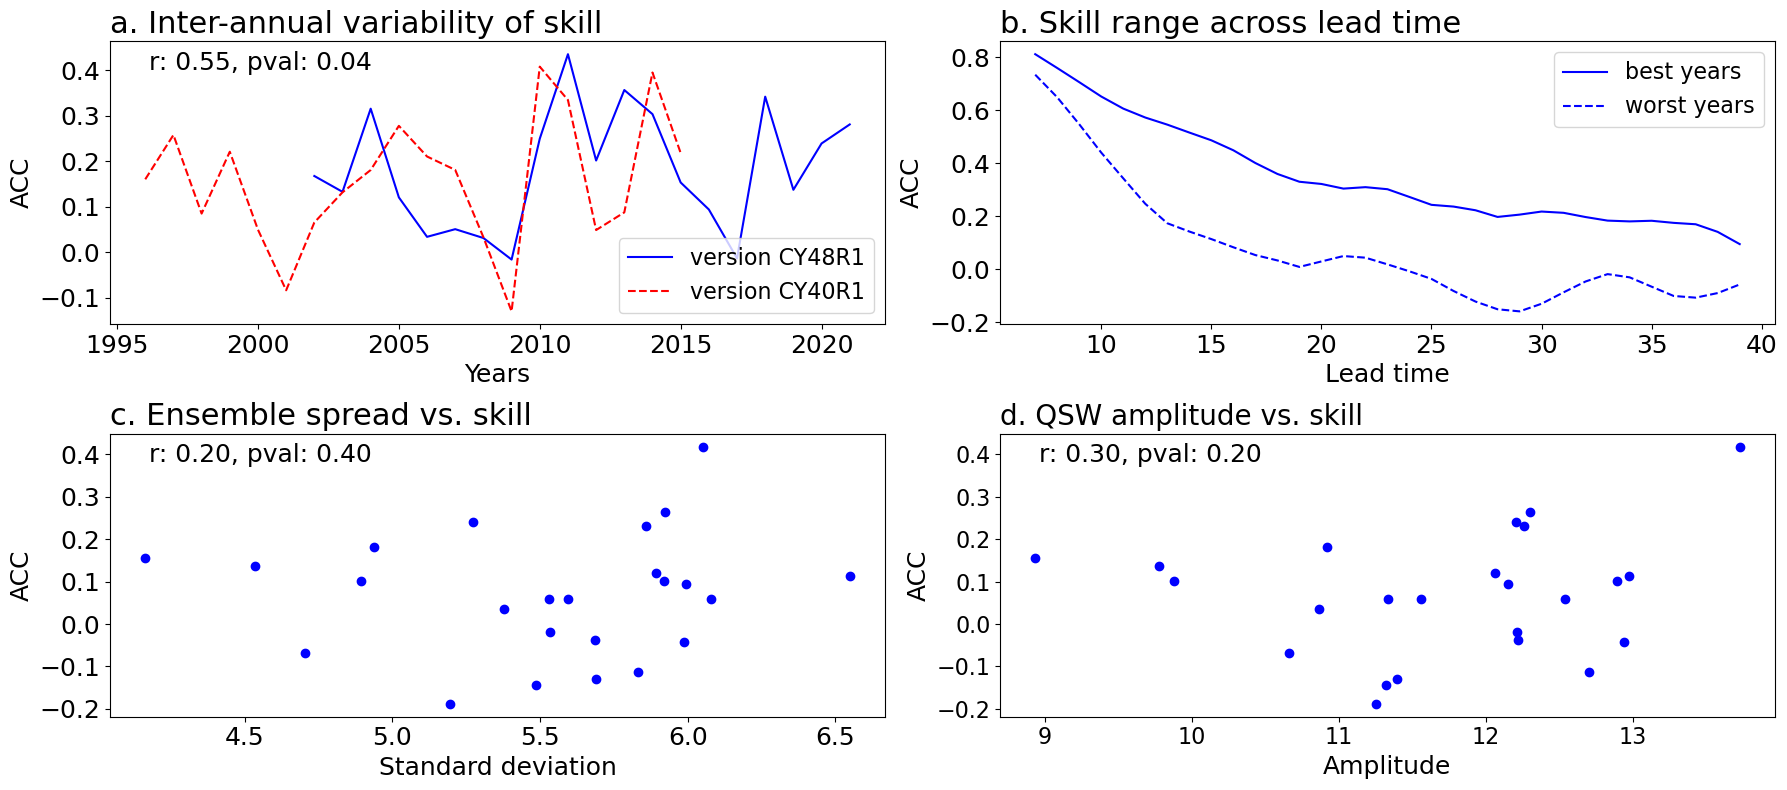

In [97]:
#Variability and best vs. worst ECMWF (pacific based)

fig=plt.figure(figsize = (18,8))


lets=['a. ','b. ','c. ', 'd. ']

ax1 = fig.add_subplot(2,2,1)

ax1.set_xlabel('Years',fontsize = 18)
ax1.set_ylabel('ACC',fontsize = 18)
# mssy_mn = msspacific[models[0]].mean(dim=['latitude','longitude','step'])

# xax=mssy_mn.years
# yax=mssy_mn #- mssy_mn.mean()
# ax.plot(xax,yax, label = 'MSS')

# plt.legend(loc ='upper right')

rs=[0.61,0.38,0.5]
ps=[0.02,0.12,0.02]
# for i in range (len(models)):
#     accy_mn = accpacific[models[i]].mean(dim=['latitude','longitude','step'])
    
#     xax=accy_mn.years
#     yax=accy_mn #- accy_mn.mean()
#     if i==0:
#         ax1.plot(xax,yax, label = models1[i])
#     else:
#         ax1.plot(xax,yax, label = models1[i]+': r='+str(rs[i-1])+',p='+str(ps[i-1]))
        
# ax1.set_title(lets[0]+'Inter-annual variability of skill',fontsize = 20)

accy_mn = accpacific[models[0]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])

xax=accy_mn.years
yax=accy_mn #- accy_mn.mean()
ax1.plot(xax,yax, label ='version CY48R1',color='b')

accy_mn2 = accpacific[models[-1]].isel(step=slice(7,21)).mean(dim=['latitude','longitude','step'])

xax=accy_mn2.years
yax=accy_mn2 #- accy_mn.mean()
ax1.plot(xax,yax, label ='version CY40R1',color='r', linestyle='dashed')
plt.legend(fontsize=16, loc='lower right')

ax1.set_title(lets[0]+'Inter-annual variability of skill',fontsize = 22,loc='left')
r="{:.2f}".format(ecxecmwf[0])
p="{:.2f}".format(ecxecmwf[1])
ax1.text(0.05,0.9,'r: '+str(r)+', pval: '+str(p),transform=ax1.transAxes,fontsize=18)


# plt.legend(fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax1 = fig.add_subplot(2,2,2)

xax=np.arange(7,40)
accpac_topyy = accpac_topy[models[0]].copy()
accpac_topyy.coords['longitude'] = accpac_topyy.coords['longitude'] % 360
accpac_topyy = accpac_topyy.sortby(accpac_topyy.longitude)
accytop_pacific=accpac_topyy.sel(longitude=slice(150,210),latitude=slice(70,50))
acc_top = accytop_pacific.mean(dim=['latitude','longitude'])
ax1.plot(xax,acc_top,label='best years',color='b')

#ax = fig.add_subplot(3,2,2*i+2)
accpac_botyy = accpac_boty[models[0]].copy()
accpac_botyy.coords['longitude'] = accpac_botyy.coords['longitude'] % 360
accpac_botyy = accpac_botyy.sortby(accpac_botyy.longitude)
accybot_pacific=accpac_botyy.sel(longitude=slice(150,210),latitude=slice(70,50))
acc_bot = accybot_pacific.mean(dim=['latitude','longitude'])

ax1.plot(xax,acc_bot,label='worst years',color='b', linestyle='dashed')
ax1.set_xlabel('Lead time',fontsize = 18)
ax1.set_ylabel('ACC',fontsize = 18)
# ax1.vlines(20,-0.02,0.26, color ='k')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)

ax1.set_title("b. Skill range across lead time",fontsize = 22,loc='left')

ax = fig.add_subplot(2,2,3)
x=qspread_yearly[models[i]].isel(step=slice(7,22)).mean(dim=['step','latitude','longitude'])
y=accpacific[models[i]].isel(step=slice(7,22)).mean(dim=['latitude','longitude','step'])

ax.scatter(x,y,color='b')
ax.set_title('c. Ensemble spread vs. skill', fontsize=22,loc='left')
ax.set_xlabel('Standard deviation',fontsize=18)
ax.set_ylabel('ACC',fontsize=18)

#Add text
r="{:.2f}".format(sprdecmwf[0])
p="{:.2f}".format(sprdecmwf[1])
ax.text(0.05,0.9,'r: '+str(r)+', pval: '+str(p),transform=ax.transAxes,fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax = fig.add_subplot(2,2,4)
x=qsw_yearly[models[i]].isel(step=slice(7,22)).mean(dim=['step','latitude','longitude'])
y=accpacific[models[i]].isel(step=slice(7,22)).mean(dim=['latitude','longitude','step'])

ax.scatter(x,y,color='b')
ax.set_title('d. QSW amplitude vs. skill', fontsize=20,loc='left')
ax.set_xlabel('Amplitude',fontsize=18)
ax.set_ylabel('ACC',fontsize=18)

#Add text
r="{:.2f}".format(ampecmwf[0])
p="{:.2f}".format(ampecmwf[1])
ax.text(0.05,0.9,'r: '+str(r)+', pval: '+str(p),transform=ax.transAxes,fontsize=18)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.savefig('plots/ECMWF_acc_variability_lead_spread_11-29.png')